In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


In [4]:
# Define data path and folder
path_phone = "C:/Users/scoup/OneDrive/Documents/GitHub/Zero-Shot-Learning-for-Obsolescence-Risk-Forecasting/data/phone_data.csv"
df_phone = pd.read_csv(path_phone, on_bad_lines='skip')

In [5]:
path_arrow = "C:/Users/scoup/OneDrive/Documents/GitHub/Zero-Shot-Learning-for-Obsolescence-Risk-Forecasting/data/arrow_data.xlsx"
df = pd.read_excel(path_arrow)


In [16]:
df.shape

(7580, 16)

## Nombre de lignes avec au moins une valeur manquante

### Analyse des données manquantes

In [24]:
missing_data_rows = df[df.isnull().any(axis=1)]
print(f"% de données manquantes est : {(len(missing_data_rows)/len(df))*100}")

% de données manquantes est : 99.78891820580475


### Analyse des différentes colonnes pour les données manquantes

In [26]:
col = df.columns
col

Index(['Reference ZENER', 'Stock', 'Fabricant', 'Type', 'Configuration',
       'Nominal Zener Voltage (V)', 'Zener volatge tolerance',
       'Maximum power dissipation (MW)', 'Test Current (MA)',
       'Maximum reverse leaking current (UA)',
       'Maximum regulator current (MA)', 'Maximum Zener impedance (OHM)',
       'Maximum power dissipation (MW', 'Packaging', 'Pin Count', 'SVHC'],
      dtype='object')

In [37]:
percentages = []
for i in range(2, 16):
   missing_col = df[df.iloc[:, i].isnull()]
   percentage = round((len(missing_col)/len(df))*100, 2)
   percentages.append(percentage)
   print(f"{col[i]} : {percentage:.2f}% de valeurs manquantes")

Fabricant : 0.00% de valeurs manquantes
Type : 2.65% de valeurs manquantes
Configuration : 2.64% de valeurs manquantes
Nominal Zener Voltage (V) : 2.48% de valeurs manquantes
Zener volatge tolerance : 2.73% de valeurs manquantes
Maximum power dissipation (MW) : 2.49% de valeurs manquantes
Test Current (MA) : 2.73% de valeurs manquantes
Maximum reverse leaking current (UA) : 4.72% de valeurs manquantes
Maximum regulator current (MA) : 72.35% de valeurs manquantes
Maximum Zener impedance (OHM) : 8.47% de valeurs manquantes
Maximum power dissipation (MW : 31.66% de valeurs manquantes
Packaging : 11.56% de valeurs manquantes
Pin Count : 1.81% de valeurs manquantes
SVHC : 46.29% de valeurs manquantes


In [39]:
percentages[1]

2.65

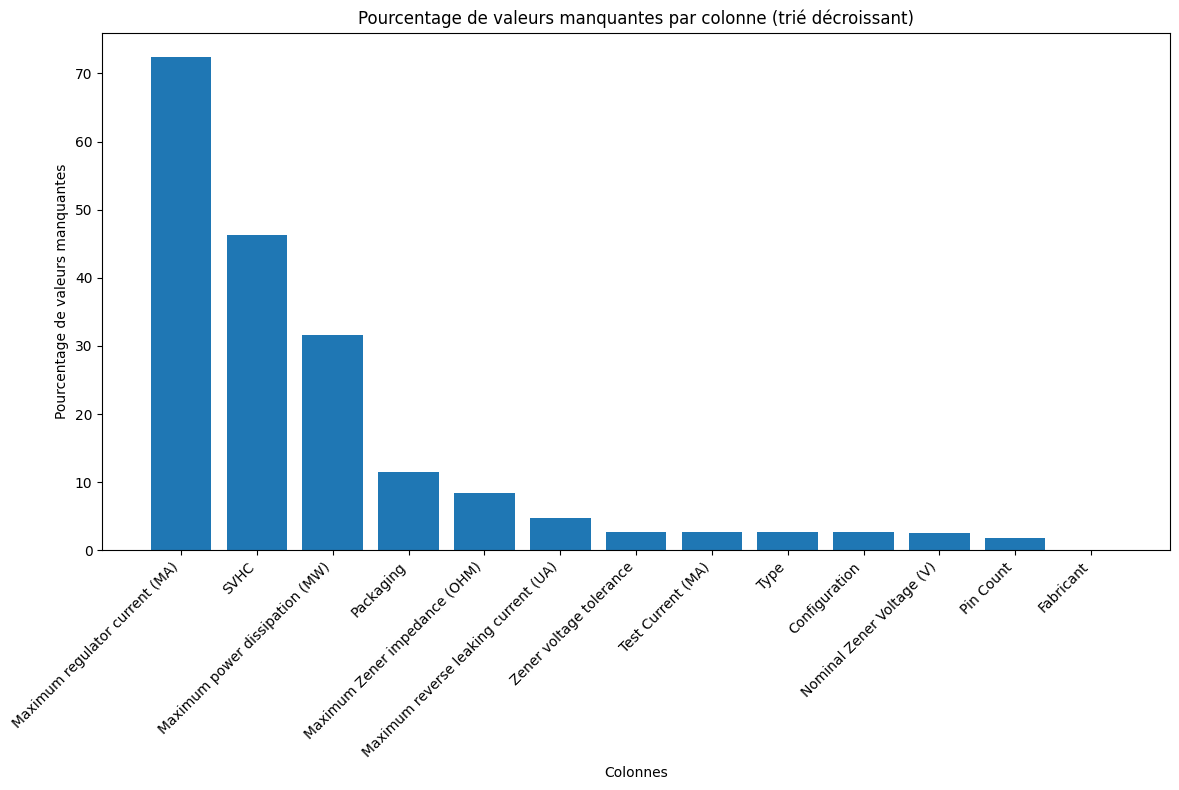

In [45]:
# Dictionnaire des pourcentages de valeurs manquantes
data = { 
   'Fabricant': percentages[0],
   'Type': percentages[1],
   'Configuration': percentages[2],
   'Nominal Zener Voltage (V)': percentages[3],
   'Zener voltage tolerance': percentages[4],
   'Maximum power dissipation (MW)': percentages[5],
   'Test Current (MA)': percentages[6],
   'Maximum reverse leaking current (UA)': percentages[7],
   'Maximum regulator current (MA)': percentages[8],
   'Maximum Zener impedance (OHM)': percentages[9],
   'Maximum power dissipation (MW)': percentages[10],  # Correction d'une erreur de syntaxe
   'Packaging': percentages[11],
   'Pin Count': percentages[12],
   'SVHC': percentages[13]
}

# Trier les données en ordre décroissant en fonction des valeurs
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Création du graphique en barres VERTICALES (bar au lieu de barh)
plt.figure(figsize=(12, 8))
plt.bar(list(sorted_data.keys()), list(sorted_data.values()))  # Utilisation de plt.bar pour vertical

# Ajout des labels et du titre
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xlabel('Colonnes')
plt.title('Pourcentage de valeurs manquantes par colonne (trié décroissant)')

# Rotation des étiquettes pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Ajustement automatique de la disposition
plt.tight_layout()

# Affichage du graphique
plt.show()

Les colonnes MA et MW sont à étudier car ils sont assez vide 
Pour la colonne des étiquettes : 46.29% de valeur manquante on va entraîner le modèle dessus

# Prétaitement des données

In [7]:
df_svhc = df[df['SVHC'] == 'Yes']
df_Nan =  df[df['SVHC'].isna()]
df_nvhc = df[df['SVHC'] == 'No']

In [8]:
df_svhc.shape

(1497, 16)

In [9]:
df_nvhc.shape

(2574, 16)

In [10]:
df_Nan.shape


(3509, 16)

In [11]:
df_train = pd.concat([df_svhc, df_nvhc])

In [12]:
df_train


,Reference ZENER,Stock,Fabricant,Type,Configuration,Nominal Zener Voltage (V),Zener volatge tolerance,Maximum power dissipation (MW),Test Current (MA),Maximum reverse leaking current (UA),Maximum regulator current (MA),Maximum Zener impedance (OHM),Maximum power dissipation (MW,Packaging,Pin Count,SVHC
0,Top Purchased\nCD0603-Z6V2 Zener Diode Single ...,2.0,Bourns,Voltage Regulator,Single,6.2,0.05,150.0,5.00,0.10,NaN,10,150.0,Tape and Reel,2.0,Yes
1,CZRER8V2B-HF Zener Diode Single 8.2V 5% 7Ohm 1...,1299.0,Comchip Technology,Voltage Regulator,Single,8.2,0.05,150.0,5.00,0.50,NaN,7,150.0,Tape and Reel,2.0,Yes
2,PDZ2.7BGWJ Diode Zener Single 2.8V 2% 625mW 2-...,8506.0,Nexperia,Voltage Regulator,Single,2.8,0.02,625.0,5.00,20.00,NaN,100,625.0,Tape and Reel,2.0,Yes
7,BZD27C200P-GS08 Diode Zener Single 200V 6% 230...,910.0,Vishay,Voltage Regulator,Single,200.0,0.06,2300.0,5.00,1.00,NaN,500,800.0,Tape and Reel,2.0,Yes
9,BZG03C11TR Zener Diode Single 11V 5% 7Ohm 3000...,2.0,Vishay,Voltage Regulator,Single,11.0,0.05,3000.0,50.00,4.00,NaN,7,NaN,Tape and Reel,2.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7517,MMBZ4714-HE3-08 Zener Diode Single 33V 5% 350m...,NaN,Vishay,Voltage Regulator,Single,33.0,0.05,350.0,0.05,0.01,NaN,NaN,350.0,Tape and Reel,3.0,No
7518,MMBZ5225B-G3-18 Zener Diode Single 3V 5% 30Ohm...,NaN,Vishay,Voltage Regulator,Single,3.0,0.05,300.0,20.00,50.00,NaN,30,300.0,Tape and Reel,3.0,No
7519,MMBZ4623-E3-18 Zener Diode Single 4.3V 5% 1600...,NaN,Vishay,Voltage Regulator,Single,4.3,0.05,350.0,0.25,4.00,65,1600,350.0,Tape and Reel,3.0,No
7522,1N4760AW-TP Zener Diode Single 68V 5% 150Ohm 1...,NaN,Micro Commercial Components,Voltage Regulator,Single,68.0,0.05,1000.0,3.70,5.00,13,150,1000.0,Tape and Reel,2.0,No


Dans la colommne "Maximum regulator current (MA)" on a des valeurs de ce type 56@Ta=50C ce qui signifique que le Maximum regulator current est 56 Ma pour une température ambiante de  50°C. On doit prendre que le Ma

# PCA pour voir les principales composantes

In [48]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Sélectionner les colonnes à encoder (en excluant la première colonne)
columns_to_encode = ['Fabricant', 'Packaging', 'Type', 'Configuration',]

# Créer un transformateur de colonnes pour l'encodage
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), columns_to_encode)
    ],
    remainder='passthrough'  # Laisser les autres colonnes inchangées
)

# Appliquer l'encodage sur le dataframe d'entraînement (en excluant la première colonne)
df_train_excl_first_col = df_train.iloc[:, 1:14]
df_encoded = column_transformer.fit_transform(df_train_excl_first_col)

# Standardiser les données encodées
df_encoded = StandardScaler().fit_transform(df_encoded)

# Effectuer la PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_encoded)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

print(principalDf)

ValueError: could not convert string to float: '50@Ta=50C'

# Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Supposons que 'SVHC' soit la variable cible
X = df_train.drop(columns=['SVHC'])
y = df_train['SVHC']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

ValueError: could not convert string to float: 'CZRF2V4B-HF Zener Diode Single 2.4V 2.5% 100Ohm 200mW 2-Pin SOD-323F T/R'